# Rain Shadow Analysis Tool

## Overview

This tool analyzes precipitation patterns between the Wasatch Front and Uinta Basin regions to quantify the rain/snow shadow effect. It processes weather station data across multiple winter periods, calculates rain shadow metrics, and analyzes pressure gradients to understand the physical mechanisms driving these weather patterns.

## Features

- **Multi-Year Analysis:** Processes data for 10 winter periods (2015-2025)
- **Rain Shadow Quantification:** Three-test methodology based on Stockham et al.
- **Pressure Gradient Analysis:** Incorporates sea level pressure data to study flow direction
- **Comprehensive Visualizations:** Multiple plot types for individual winters and long-term trends

## Requirements

- Python 3.7+
- Dependencies:
  ```
  polars
  numpy
  matplotlib
  seaborn
  synoptic
  ```

## Installation

1. Clone this repository
2. Install required packages:
   ```bash
   pip install polars numpy matplotlib seaborn synoptic
   ```
3. Set your Synoptic API token in the script

## Usage

```bash
python rain_shadow_analysis.py
```

## Configuration

Modify the `winter_periods` list to adjust the date ranges for analysis. Each winter should include chunks for December through March.

```python
winter_periods = [
    {
        "name": "Winter 2024-2025",
        "chunks": [
            {"start": datetime(2024, 12, 1), "end": datetime(2024, 12, 31), "month": "Dec 2024"},
            # other months...
        ]
    },
    # other winters...
]
```

## Data Sources

The script uses precipitation and pressure data from weather stations in:

- **Wasatch Front:** Salt Lake City, Ogden, Farmington, Centerville, Provo
- **Uinta Basin:** Duchesne, Myton, Fort Duchesne, Vernal, Jensen

## Output

### Individual Winter Analysis
- Precipitation pattern distributions
- Monthly shadow patterns
- Pressure gradient histograms
- Correlation scatter plots
- Rain shadow heatmaps

### Multi-Year Analysis
- Rain shadow trends over time
- Precipitation pattern evolution
- Monthly shadow percentage heatmaps
- Pressure gradient trends

## Methodology

1. **Data Collection:** Retrieves data from weather stations via Synoptic API
2. **Flow Classification:** Determines flow direction using pressure gradients
3. **Rain Shadow Tests:**
   - Compare average precipitation amounts
   - Compare frequency of precipitation days
   - Analyze day-by-day precipitation patterns
4. **Pattern Classification:**
   - Rain Shadow: Precipitation upwind only
   - Reverse Shadow: Precipitation downwind only
   - Both Rainy: Precipitation in both regions
   - Both Dry: No precipitation in either region

## Interpretation

The analysis reveals several key findings:
- Westerly flow consistently produces strong rain shadow effects
- Easterly flow rarely creates rain shadows but frequently causes reverse shadow events
- Clear relationship between pressure gradients and precipitation patterns
- Seasonal variations in rain shadow intensity
- Year-to-year fluctuations worth further investigation

## Example Output

```
=== RAIN SHADOW ANALYSIS SUMMARY ===

Comparison of Westerly and Easterly Flows:
------------------------------------------------------------
Statistic                           Westerly     Easterly
------------------------------------------------------------
Total days                          83           37
Days with rain at upwind location   50           8
Percentage of days with rain upwind 60.2%       21.6%
Days with rain shadow               37           1
Days with reverse rain shadow       1            13
...
```

## License

This tool is provided for research and educational purposes.

Analyzing snow shadow effect between Uinta Basin and Wasatch Front
Focusing on winter months (December-March)

=== STATIONS FOR ANALYSIS ===

Wasatch Front Stations:
  Precipitation: KOGD (Ogden-Hinckley Airport), AP611 (KJ7NO-2 Farmington), C8948 (Centerville 1427), KSLC (Salt Lake City), COOPPROU1 (PROVO BYU)
  Sea Level Pressure: KSLC (Salt Lake City)

Uinta Basin Stations:
  Precipitation: COOPDSNU1 (DUCHESNE), COOPMYTU1 (MYTON), COOPFTDU1 (FORT DUCHESNE), KVEL (Vernal Airport), COOPJENU1 (JENSEN)
  Sea Level Pressure: KVEL (Vernal Airport)

=== BEGINNING INDIVIDUAL WINTER ANALYSIS ===

===== ANALYZING RAIN SHADOW EFFECT FOR Winter 2024-2025 =====

--- CREATING DAILY DATASET FOR Winter 2024-2025 ---

Retrieving Uinta Basin precipitation data...
  Retrieving precip_accum_24_hour data for Dec 2024 from COOPDSNU1 (DUCHESNE)...
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 1 stations (0.24 seconds).
    Retrieved 30 records
  Retrieving precip_accum_24_hou

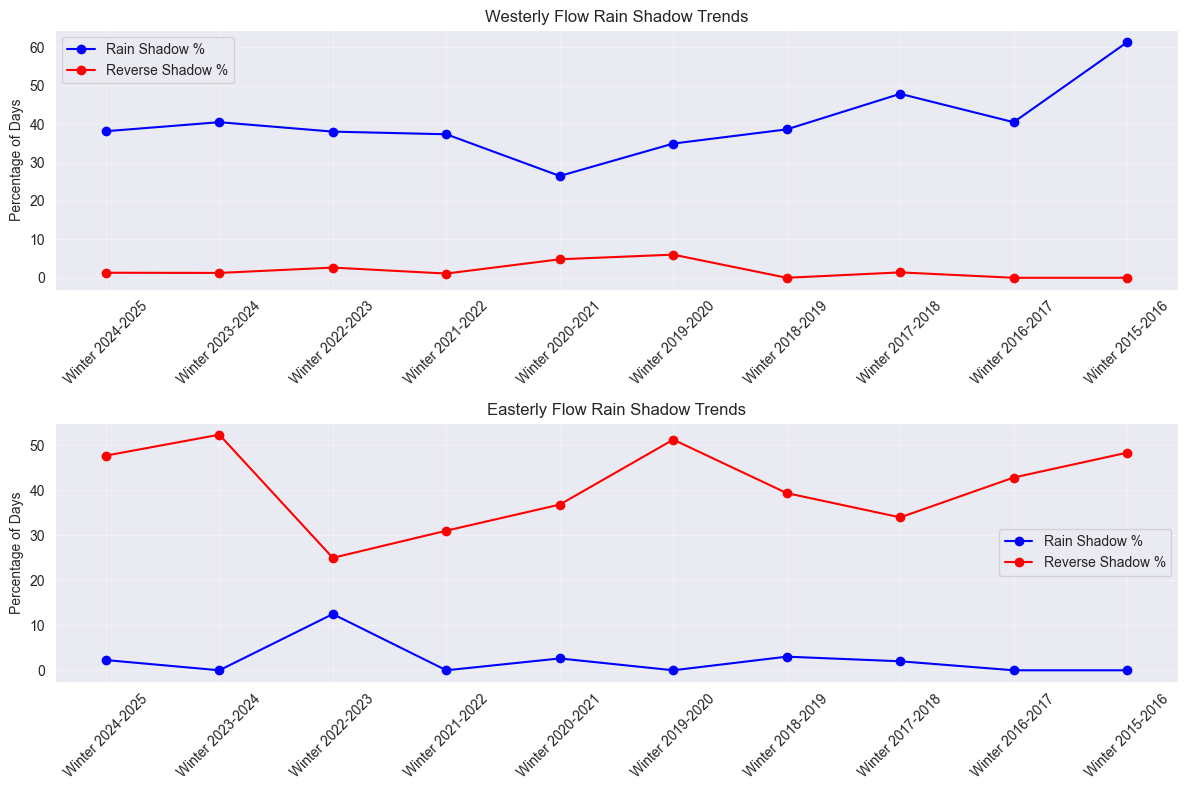

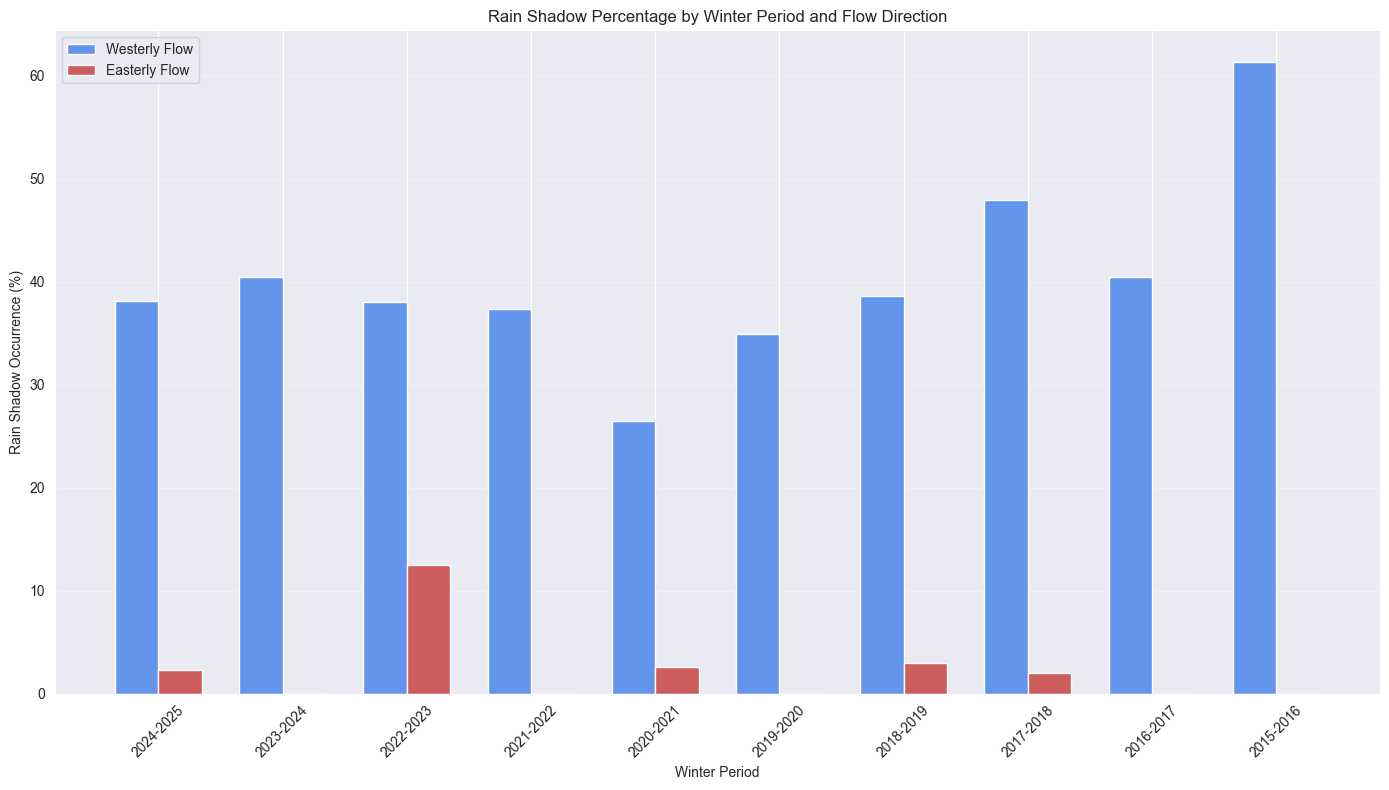

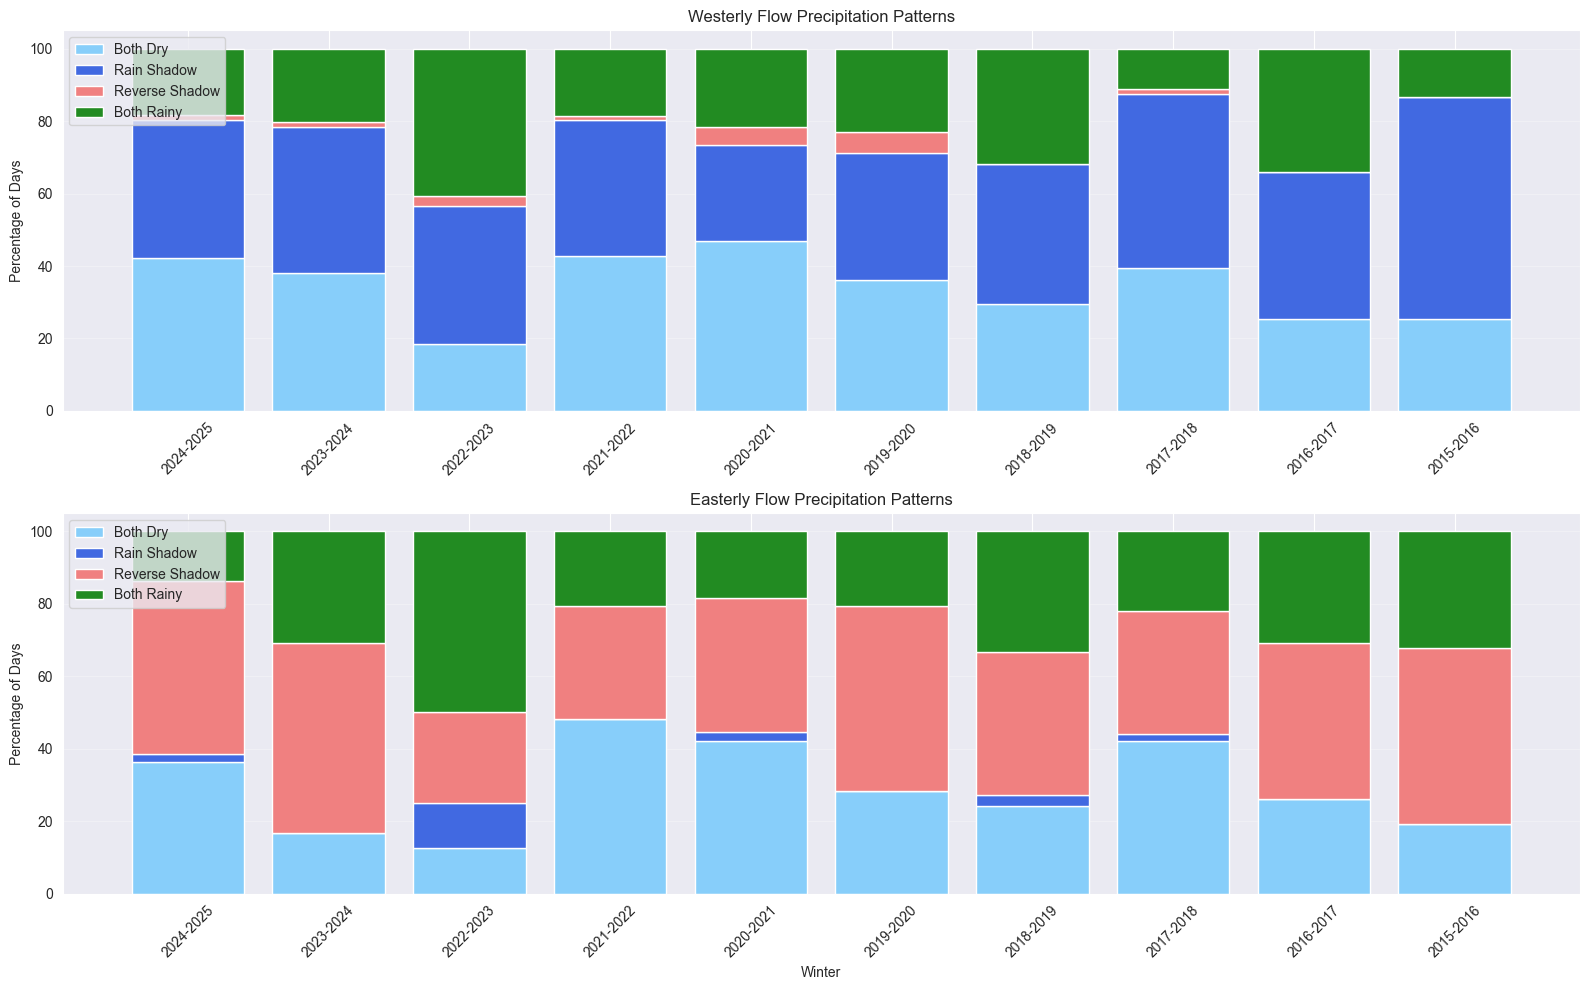

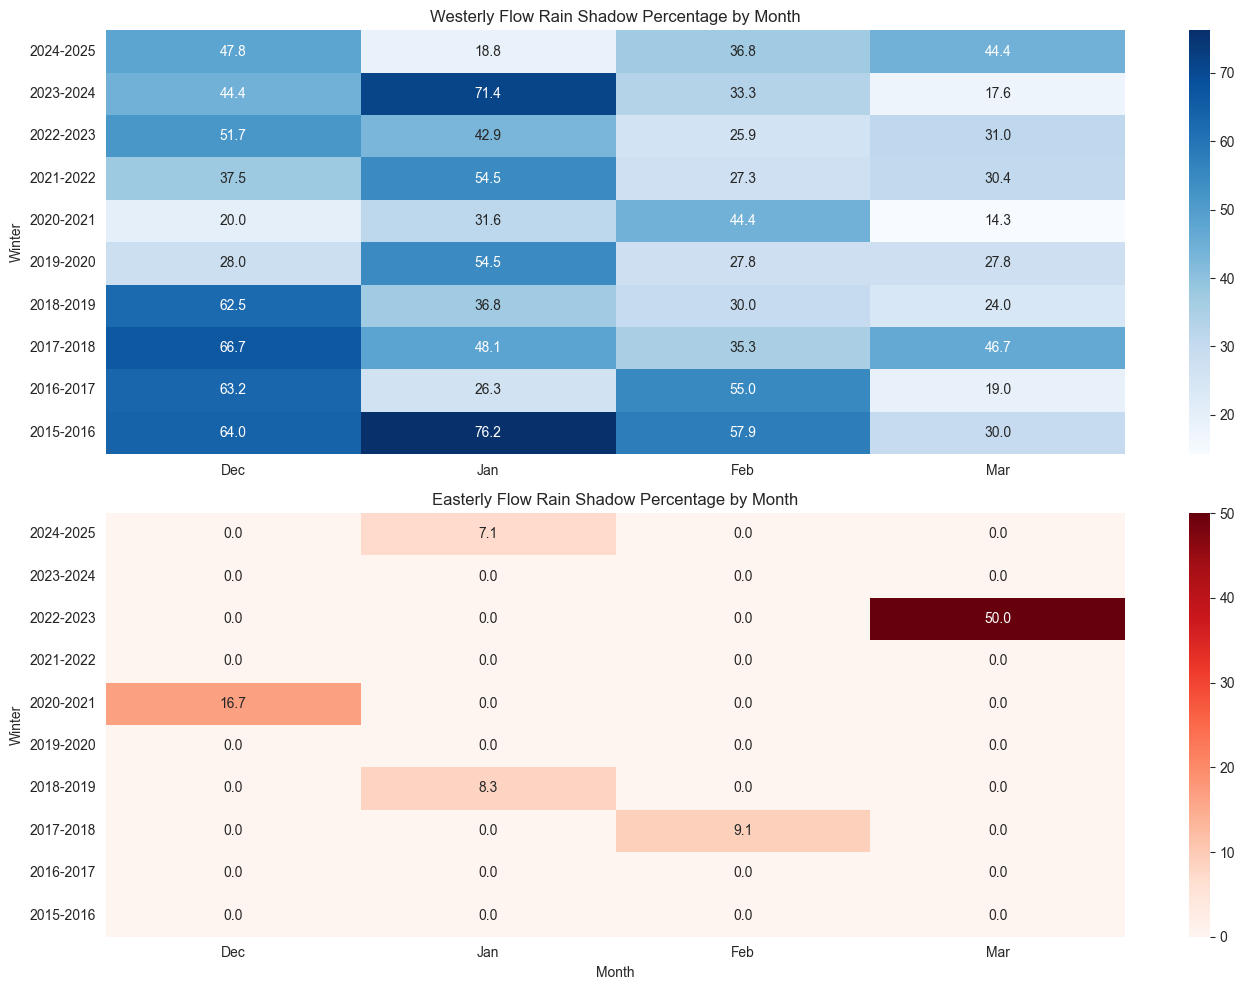

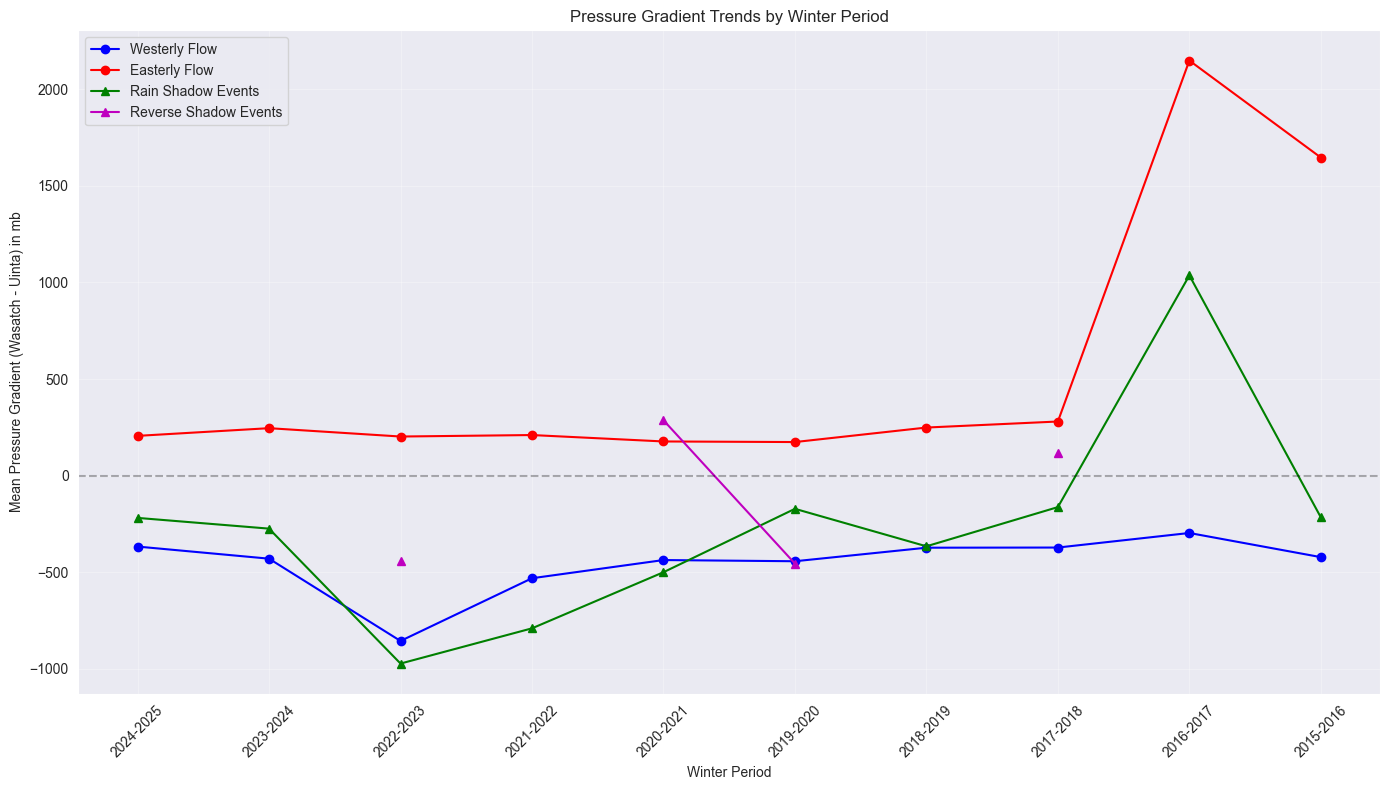

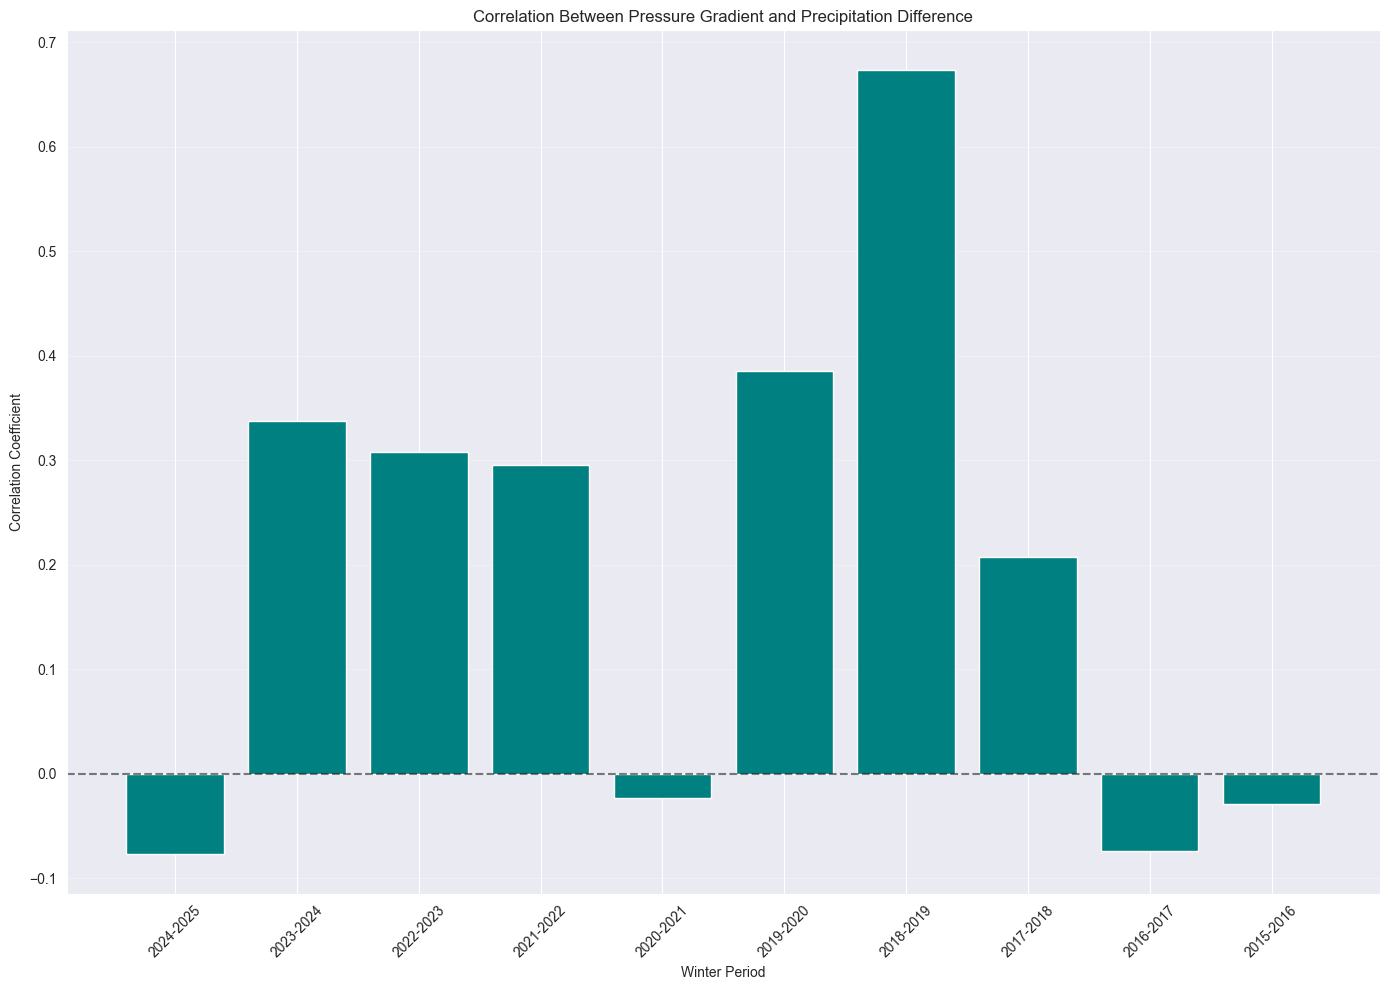

In [5]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import seaborn as sns
import synoptic
import traceback

# Set token
token = "YOUR_TOKEN_HERE"

# Define winter periods to analyze (Dec-Mar only) - include ALL winters you want to analyze
# This should include at least 5-10 years of data for a proper long-term analysis
winter_periods = [
    # Winter 2024-2025 (current)
    {
        "name": "Winter 2024-2025",
        "chunks": [
            {"start": datetime(2024, 12, 1), "end": datetime(2024, 12, 31), "month": "Dec 2024"},
            {"start": datetime(2025, 1, 1), "end": datetime(2025, 1, 31), "month": "Jan 2025"},
            {"start": datetime(2025, 2, 1), "end": datetime(2025, 2, 28), "month": "Feb 2025"},
            {"start": datetime(2025, 3, 1), "end": datetime(2025, 3, 31), "month": "Mar 2025"}
        ]
    },
    # Winter 2023-2024
    {
        "name": "Winter 2023-2024",
        "chunks": [
            {"start": datetime(2023, 12, 1), "end": datetime(2023, 12, 31), "month": "Dec 2023"},
            {"start": datetime(2024, 1, 1), "end": datetime(2024, 1, 31), "month": "Jan 2024"},
            {"start": datetime(2024, 2, 1), "end": datetime(2024, 2, 29), "month": "Feb 2024"},
            {"start": datetime(2024, 3, 1), "end": datetime(2024, 3, 31), "month": "Mar 2024"}
        ]
    },
    # Winter 2022-2023
    {
        "name": "Winter 2022-2023",
        "chunks": [
            {"start": datetime(2022, 12, 1), "end": datetime(2022, 12, 31), "month": "Dec 2022"},
            {"start": datetime(2023, 1, 1), "end": datetime(2023, 1, 31), "month": "Jan 2023"},
            {"start": datetime(2023, 2, 1), "end": datetime(2023, 2, 28), "month": "Feb 2023"},
            {"start": datetime(2023, 3, 1), "end": datetime(2023, 3, 31), "month": "Mar 2023"}
        ]
    },
    # Winter 2021-2022
    {
        "name": "Winter 2021-2022",
        "chunks": [
            {"start": datetime(2021, 12, 1), "end": datetime(2021, 12, 31), "month": "Dec 2021"},
            {"start": datetime(2022, 1, 1), "end": datetime(2022, 1, 31), "month": "Jan 2022"},
            {"start": datetime(2022, 2, 1), "end": datetime(2022, 2, 28), "month": "Feb 2022"},
            {"start": datetime(2022, 3, 1), "end": datetime(2022, 3, 31), "month": "Mar 2022"}
        ]
    },
    # Winter 2020-2021
    {
        "name": "Winter 2020-2021",
        "chunks": [
            {"start": datetime(2020, 12, 1), "end": datetime(2020, 12, 31), "month": "Dec 2020"},
            {"start": datetime(2021, 1, 1), "end": datetime(2021, 1, 31), "month": "Jan 2021"},
            {"start": datetime(2021, 2, 1), "end": datetime(2021, 2, 28), "month": "Feb 2021"},
            {"start": datetime(2021, 3, 1), "end": datetime(2021, 3, 31), "month": "Mar 2021"}
        ]
    },
    # Winter 2019-2020
    {
        "name": "Winter 2019-2020",
        "chunks": [
            {"start": datetime(2019, 12, 1), "end": datetime(2019, 12, 31), "month": "Dec 2019"},
            {"start": datetime(2020, 1, 1), "end": datetime(2020, 1, 31), "month": "Jan 2020"},
            {"start": datetime(2020, 2, 1), "end": datetime(2020, 2, 29), "month": "Feb 2020"},
            {"start": datetime(2020, 3, 1), "end": datetime(2020, 3, 31), "month": "Mar 2020"}
        ]
    },
    # Winter 2018-2019
    {
        "name": "Winter 2018-2019",
        "chunks": [
            {"start": datetime(2018, 12, 1), "end": datetime(2018, 12, 31), "month": "Dec 2018"},
            {"start": datetime(2019, 1, 1), "end": datetime(2019, 1, 31), "month": "Jan 2019"},
            {"start": datetime(2019, 2, 1), "end": datetime(2019, 2, 28), "month": "Feb 2019"},
            {"start": datetime(2019, 3, 1), "end": datetime(2019, 3, 31), "month": "Mar 2019"}
        ]
    },
    # Winter 2017-2018
    {
        "name": "Winter 2017-2018",
        "chunks": [
            {"start": datetime(2017, 12, 1), "end": datetime(2017, 12, 31), "month": "Dec 2017"},
            {"start": datetime(2018, 1, 1), "end": datetime(2018, 1, 31), "month": "Jan 2018"},
            {"start": datetime(2018, 2, 1), "end": datetime(2018, 2, 28), "month": "Feb 2018"},
            {"start": datetime(2018, 3, 1), "end": datetime(2018, 3, 31), "month": "Mar 2018"}
        ]
    },
    # Winter 2016-2017
    {
        "name": "Winter 2016-2017",
        "chunks": [
            {"start": datetime(2016, 12, 1), "end": datetime(2016, 12, 31), "month": "Dec 2016"},
            {"start": datetime(2017, 1, 1), "end": datetime(2017, 1, 31), "month": "Jan 2017"},
            {"start": datetime(2017, 2, 1), "end": datetime(2017, 2, 28), "month": "Feb 2017"},
            {"start": datetime(2017, 3, 1), "end": datetime(2017, 3, 31), "month": "Mar 2017"}
        ]
    },
    # Winter 2015-2016
    {
        "name": "Winter 2015-2016",
        "chunks": [
            {"start": datetime(2015, 12, 1), "end": datetime(2015, 12, 31), "month": "Dec 2015"},
            {"start": datetime(2016, 1, 1), "end": datetime(2016, 1, 31), "month": "Jan 2016"},
            {"start": datetime(2016, 2, 1), "end": datetime(2016, 2, 29), "month": "Feb 2016"},
            {"start": datetime(2016, 3, 1), "end": datetime(2016, 3, 31), "month": "Mar 2016"}
        ]
    }
]

print("Analyzing snow shadow effect between Uinta Basin and Wasatch Front")
print("Focusing on winter months (December-March)")

# Define specific stations for each region - streamlined to only those being used
wasatch_front_stations = {
    "precip_accum_24_hour": ["KOGD", "AP611", "C8948", "KSLC", "COOPPROU1"],
    "sea_level_pressure": ["KSLC"]
}

uinta_basin_stations = {
    "precip_accum_24_hour": ["COOPDSNU1", "COOPMYTU1", "COOPFTDU1", "KVEL", "COOPJENU1"],
    "sea_level_pressure": ["KVEL"]
}

# Station name mappings
station_names = {
    # Wasatch Front
    "KSLC": "Salt Lake City",
    "KOGD": "Ogden-Hinckley Airport",
    "AP611": "KJ7NO-2 Farmington",
    "C8948": "Centerville 1427",
    "COOPPROU1": "PROVO BYU",

    # Uinta Basin
    "COOPDSNU1": "DUCHESNE",
    "COOPMYTU1": "MYTON",
    "COOPFTDU1": "FORT DUCHESNE",
    "KVEL": "Vernal Airport",
    "COOPJENU1": "JENSEN"
}

print("\n=== STATIONS FOR ANALYSIS ===")
print("\nWasatch Front Stations:")
print("  Precipitation: " + ", ".join([f"{id} ({station_names[id]})" for id in wasatch_front_stations['precip_accum_24_hour']]))
print("  Sea Level Pressure: " + ", ".join([f"{id} ({station_names[id]})" for id in wasatch_front_stations['sea_level_pressure']]))

print("\nUinta Basin Stations:")
print("  Precipitation: " + ", ".join([f"{id} ({station_names[id]})" for id in uinta_basin_stations['precip_accum_24_hour']]))
print("  Sea Level Pressure: " + ", ".join([f"{id} ({station_names[id]})" for id in uinta_basin_stations['sea_level_pressure']]))

def collect_monthly_data(station, winter, variable):
    """Collect data for a station across all months of winter period"""
    all_data = []

    for chunk in winter['chunks']:
        try:
            print(f"  Retrieving {variable} data for {chunk['month']} from {station} ({station_names[station]})...")
            data = synoptic.TimeSeries(
                stid=station,
                start=chunk['start'],
                end=chunk['end'],
                vars=variable,
                token=token
            ).df()

            if data is not None and len(data) > 0:
                all_data.append(data)
                print(f"    Retrieved {len(data)} records")
            else:
                print(f"    No data available")

        except Exception as e:
            print(f"    Error: {e}")

    # Combine all monthly chunks
    if all_data:
        try:
            combined_data = pl.concat(all_data)
            return combined_data
        except Exception as e:
            print(f"Error combining data: {e}")
            # Return the first chunk if we can't combine
            if len(all_data) > 0:
                return all_data[0]

    return None

def collect_regional_data(stations, winter, variable):
    """Collect data from all stations in a region for a variable"""
    all_station_data = []
    used_stations = []

    for station in stations:
        station_data = collect_monthly_data(station, winter, variable)
        if station_data is not None and len(station_data) > 0:
            # Add station identifier column
            station_data = station_data.with_columns(pl.lit(station).alias("station"))
            all_station_data.append(station_data)
            used_stations.append(station)

    # Combine all station data
    if all_station_data:
        try:
            combined_data = pl.concat(all_station_data)
            return combined_data, used_stations
        except Exception as e:
            print(f"Error combining station data: {e}")
            return None, []

    return None, []

def generate_simulated_flow_direction(start_date, end_date):
    """
    Create simulated flow direction when pressure data is unavailable.
    Used as a fallback when actual measurements aren't available.
    """
    days = []
    current_date = start_date
    while current_date <= end_date:
        # Simulate westerly flow for 70% of days and easterly for 30%
        flow = "westerly" if np.random.random() < 0.7 else "easterly"
        days.append({"date": current_date, "flow_direction": flow})
        current_date += timedelta(days=1)

    return pl.DataFrame(days)

def create_daily_dataset(winter):
    """
    Create daily dataset with precipitation and pressure data.
    Determine flow direction based on pressure gradients when available.
    """
    print(f"\n--- CREATING DAILY DATASET FOR {winter['name']} ---")

    # Get precipitation data for both regions
    print(f"\nRetrieving Uinta Basin precipitation data...")
    uinta_precip, uinta_stations_used = collect_regional_data(
        uinta_basin_stations["precip_accum_24_hour"], winter, "precip_accum_24_hour"
    )

    print(f"\nRetrieving Wasatch Front precipitation data...")
    wasatch_precip, wasatch_stations_used = collect_regional_data(
        wasatch_front_stations["precip_accum_24_hour"], winter, "precip_accum_24_hour"
    )

    # Get sea level pressure data
    print(f"\nRetrieving sea level pressure data...")
    wasatch_pressure, wasatch_pressure_stations = collect_regional_data(
        wasatch_front_stations["sea_level_pressure"], winter, "sea_level_pressure"
    )
    uinta_pressure, uinta_pressure_stations = collect_regional_data(
        uinta_basin_stations["sea_level_pressure"], winter, "sea_level_pressure"
    )

    # Create daily dataset
    if uinta_precip is not None and wasatch_precip is not None:
        try:
            # Process precipitation data
            uinta_daily = uinta_precip.group_by(
                [pl.col("date_time").dt.date(), "station"]
            ).agg(
                pl.col("value").sum().alias("daily_precip")
            )
            uinta_region_daily = uinta_daily.group_by(
                pl.col("date_time")
            ).agg(
                pl.col("daily_precip").mean().alias("uinta_basin_precip")
            ).sort("date_time")

            wasatch_daily = wasatch_precip.group_by(
                [pl.col("date_time").dt.date(), "station"]
            ).agg(
                pl.col("value").sum().alias("daily_precip")
            )
            wasatch_region_daily = wasatch_daily.group_by(
                pl.col("date_time")
            ).agg(
                pl.col("daily_precip").mean().alias("wasatch_front_precip")
            ).sort("date_time")

            # Join precipitation data
            daily_data = uinta_region_daily.join(
                wasatch_region_daily,
                on="date_time",
                how="full"
            )

            # Fill missing precipitation values with 0
            daily_data = daily_data.with_columns([
                pl.col("uinta_basin_precip").fill_null(0),
                pl.col("wasatch_front_precip").fill_null(0)
            ])

            # Process and join pressure data if available
            has_pressure_data = False
            if wasatch_pressure is not None and uinta_pressure is not None:
                try:
                    wasatch_pressure_daily = wasatch_pressure.group_by(
                        pl.col("date_time").dt.date()
                    ).agg(
                        pl.col("value").mean().alias("wasatch_front_pressure")
                    ).sort("date_time")

                    uinta_pressure_daily = uinta_pressure.group_by(
                        pl.col("date_time").dt.date()
                    ).agg(
                        pl.col("value").mean().alias("uinta_basin_pressure")
                    ).sort("date_time")

                    daily_data = daily_data.join(
                        wasatch_pressure_daily,
                        left_on="date_time",
                        right_on="date_time",
                        how="left"
                    ).join(
                        uinta_pressure_daily,
                        left_on="date_time",
                        right_on="date_time",
                        how="left"
                    )

                    # Calculate pressure gradient (positive = higher pressure in Wasatch)
                    daily_data = daily_data.with_columns(
                        (pl.col("wasatch_front_pressure") - pl.col("uinta_basin_pressure")).alias("pressure_gradient")
                    )
                    has_pressure_data = True
                    print(f"Added pressure data from {wasatch_pressure_stations} (Wasatch) and {uinta_pressure_stations} (Uinta)")
                except Exception as e:
                    print(f"Error adding pressure data: {e}")
                    has_pressure_data = False

            # Rename date_time to date for clarity
            daily_data = daily_data.rename({"date_time": "date"})

            # Generate flow direction data
            min_date = daily_data["date"].min()
            max_date = daily_data["date"].max()
            simulated_flow = generate_simulated_flow_direction(min_date, max_date)

            # Use pressure gradient to determine flow when available, otherwise use simulated
            if has_pressure_data:
                daily_data = daily_data.join(
                    simulated_flow,
                    on="date",
                    how="left"
                )

                daily_data = daily_data.with_columns(
                    pl.when(pl.col("pressure_gradient").is_not_null())
                    .then(
                        pl.when(pl.col("pressure_gradient") > 0.5)
                        .then(pl.lit("easterly"))  # Higher pressure in Wasatch -> easterly flow
                        .when(pl.col("pressure_gradient") < -0.5)
                        .then(pl.lit("westerly"))  # Higher pressure in Uinta -> westerly flow
                        .otherwise(pl.col("flow_direction"))
                    )
                    .otherwise(pl.col("flow_direction"))
                    .alias("flow_direction")
                )
            else:
                daily_data = daily_data.join(
                    simulated_flow,
                    on="date",
                    how="left"
                )

            # Add winter month information
            daily_data = daily_data.with_columns(
                pl.when(pl.col("date").dt.month() == 12)
                .then(pl.lit(0))  # December
                .when(pl.col("date").dt.month() == 1)
                .then(pl.lit(1))  # January
                .when(pl.col("date").dt.month() == 2)
                .then(pl.lit(2))  # February
                .when(pl.col("date").dt.month() == 3)
                .then(pl.lit(3))  # March
                .otherwise(pl.lit(-1))
                .alias("winter_month_idx")
            )

            # Add month name
            daily_data = daily_data.with_columns(
                pl.when(pl.col("winter_month_idx") == 0)
                .then(pl.lit("Dec"))
                .when(pl.col("winter_month_idx") == 1)
                .then(pl.lit("Jan"))
                .when(pl.col("winter_month_idx") == 2)
                .then(pl.lit("Feb"))
                .when(pl.col("winter_month_idx") == 3)
                .then(pl.lit("Mar"))
                .otherwise(pl.lit("Unknown"))
                .alias("winter_month")
            )

            # Add year and create month-year label
            daily_data = daily_data.with_columns(
                pl.col("date").dt.year().cast(pl.Utf8).alias("year"),
            ).with_columns(
                (pl.col("winter_month") + " " + pl.col("year")).alias("winter_month_label")
            )

            print(f"Created daily dataset with {len(daily_data)} days")
            return daily_data, uinta_stations_used, wasatch_stations_used

        except Exception as e:
            print(f"Error creating daily dataset: {e}")
            traceback.print_exc()
            return None, [], []
    else:
        if uinta_precip is None:
            print("No precipitation data available for Uinta Basin stations")
        if wasatch_precip is None:
            print("No precipitation data available for Wasatch Front stations")
        return None, [], []

def perform_rain_shadow_tests(daily_data, threshold=0.1):
    """
    Analyze precipitation patterns to identify rain shadow effects.
    Tests follow methodology from Stockham et al.
    """
    results = {
        'westerly': {},
        'easterly': {}
    }

    # Filter data by flow direction
    westerly_data = daily_data.filter(pl.col("flow_direction") == "westerly")
    easterly_data = daily_data.filter(pl.col("flow_direction") == "easterly")

    # Process data for each flow direction
    for flow_type, data in [('westerly', westerly_data), ('easterly', easterly_data)]:
        # Determine upwind and downwind regions based on flow direction
        if flow_type == 'westerly':
            upwind_region = 'wasatch_front_precip'
            downwind_region = 'uinta_basin_precip'
        else:
            upwind_region = 'uinta_basin_precip'
            downwind_region = 'wasatch_front_precip'

        # Test 1: Compare average precipitation amounts
        upwind_precip = data[upwind_region].mean()
        downwind_precip = data[downwind_region].mean()
        precip_diff = upwind_precip - downwind_precip
        precip_ratio = (upwind_precip / downwind_precip) if downwind_precip > 0 else float('inf')

        results[flow_type]['test1'] = {
            'upwind_avg_precip': upwind_precip,
            'downwind_avg_precip': downwind_precip,
            'difference': precip_diff,
            'ratio': precip_ratio,
            'is_rain_shadow': precip_diff > 0
        }

        # Test 2: Compare frequency of precipitation days
        upwind_rainy_days = (data[upwind_region] >= threshold).sum()
        downwind_rainy_days = (data[downwind_region] >= threshold).sum()
        days_diff = upwind_rainy_days - downwind_rainy_days
        days_ratio = (upwind_rainy_days / downwind_rainy_days) if downwind_rainy_days > 0 else float('inf')

        results[flow_type]['test2'] = {
            'upwind_rainy_days': upwind_rainy_days,
            'downwind_rainy_days': downwind_rainy_days,
            'difference': days_diff,
            'ratio': days_ratio,
            'is_rain_shadow': days_diff > 0
        }

        # Test 3: Day-by-day rain pattern analysis
        rainy_both = ((data[upwind_region] >= threshold) &
                     (data[downwind_region] >= threshold)).sum()

        rain_shadow_days = ((data[upwind_region] >= threshold) &
                          (data[downwind_region] < threshold)).sum()

        reverse_rain_shadow = ((data[upwind_region] < threshold) &
                             (data[downwind_region] >= threshold)).sum()

        dry_both = ((data[upwind_region] < threshold) &
                  (data[downwind_region] < threshold)).sum()

        total_days = len(data)

        results[flow_type]['test3'] = {
            'total_days': total_days,
            'rainy_both': rainy_both,
            'rain_shadow_days': rain_shadow_days,
            'reverse_rain_shadow': reverse_rain_shadow,
            'dry_both': dry_both,
            'rain_shadow_percentage': (rain_shadow_days / total_days) * 100 if total_days > 0 else 0,
            'ratio_shadow_to_reverse': (rain_shadow_days / reverse_rain_shadow) if reverse_rain_shadow > 0 else float('inf'),
            'ratio_both_rainy_to_shadow': (rainy_both / rain_shadow_days) if rain_shadow_days > 0 else float('inf')
        }

    return results

def analyze_pressure_patterns(daily_data, winter_name):
    """
    Analyze relationship between pressure gradients and precipitation patterns.
    """
    if "pressure_gradient" not in daily_data.columns:
        print("No pressure gradient data available for analysis")
        return

    # Filter out rows with missing pressure data
    valid_data = daily_data.filter(pl.col("pressure_gradient").is_not_null())

    if len(valid_data) == 0:
        print("No valid pressure gradient data available")
        return

    # Calculate statistics
    westerly_pressure = valid_data.filter(pl.col("flow_direction") == "westerly")
    easterly_pressure = valid_data.filter(pl.col("flow_direction") == "easterly")
    rain_shadow_pressure = valid_data.filter(
        (pl.col("wasatch_front_precip") >= 0.1) &
        (pl.col("uinta_basin_precip") < 0.1)
    )
    reverse_shadow_pressure = valid_data.filter(
        (pl.col("wasatch_front_precip") < 0.1) &
        (pl.col("uinta_basin_precip") >= 0.1)
    )

    stats = {
        "westerly_gradient_mean": westerly_pressure["pressure_gradient"].mean() if len(westerly_pressure) > 0 else None,
        "easterly_gradient_mean": easterly_pressure["pressure_gradient"].mean() if len(easterly_pressure) > 0 else None,
        "rain_shadow_gradient_mean": rain_shadow_pressure["pressure_gradient"].mean() if len(rain_shadow_pressure) > 0 else None,
        "reverse_shadow_gradient_mean": reverse_shadow_pressure["pressure_gradient"].mean() if len(reverse_shadow_pressure) > 0 else None
    }

    print("\n=== PRESSURE GRADIENT ANALYSIS ===")
    print(f"Mean pressure gradient during westerly flow: {stats['westerly_gradient_mean']:.2f} mb" if stats['westerly_gradient_mean'] is not None else "No westerly flow data")
    print(f"Mean pressure gradient during easterly flow: {stats['easterly_gradient_mean']:.2f} mb" if stats['easterly_gradient_mean'] is not None else "No easterly flow data")
    print(f"Mean pressure gradient during rain shadow events: {stats['rain_shadow_gradient_mean']:.2f} mb" if stats['rain_shadow_gradient_mean'] is not None else "No rain shadow events")
    print(f"Mean pressure gradient during reverse shadow events: {stats['reverse_shadow_gradient_mean']:.2f} mb" if stats['reverse_shadow_gradient_mean'] is not None else "No reverse shadow events")

    # Plot pressure gradient distribution
    plt.figure(figsize=(10, 6))

    # Gather pressure data for plotting
    westerly_pressures = westerly_pressure["pressure_gradient"].to_numpy() if len(westerly_pressure) > 0 else np.array([])
    easterly_pressures = easterly_pressure["pressure_gradient"].to_numpy() if len(easterly_pressure) > 0 else np.array([])

    if len(westerly_pressures) > 0 or len(easterly_pressures) > 0:
        bins = np.linspace(
            min(westerly_pressures.min() if len(westerly_pressures) > 0 else 0,
                easterly_pressures.min() if len(easterly_pressures) > 0 else 0) - 0.5,
            max(westerly_pressures.max() if len(westerly_pressures) > 0 else 0,
                easterly_pressures.max() if len(easterly_pressures) > 0 else 0) + 0.5,
            20
        )

        if len(westerly_pressures) > 0 and len(easterly_pressures) > 0:
            plt.hist([westerly_pressures, easterly_pressures], bins=bins,
                     label=['Westerly Flow', 'Easterly Flow'], alpha=0.7)
        elif len(westerly_pressures) > 0:
            plt.hist(westerly_pressures, bins=bins, label='Westerly Flow', alpha=0.7)
        elif len(easterly_pressures) > 0:
            plt.hist(easterly_pressures, bins=bins, label='Easterly Flow', alpha=0.7)

        plt.axvline(x=0, color='black', linestyle='--')
        plt.xlabel("Pressure Gradient (Wasatch - Uinta) in mb")
        plt.ylabel("Frequency")
        plt.title(f"Pressure Gradient Distribution by Flow Direction - {winter_name}")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()

        filename = f"pressure_gradient_distribution_{winter_name.replace(' ', '_').lower()}.png"
        plt.savefig(filename)
        print(f"Pressure gradient analysis saved as {filename}")
    else:
        print("Insufficient pressure data for histogram")

    # Create scatterplot of pressure gradient vs. precipitation difference
    plt.figure(figsize=(10, 6))

    if len(valid_data) > 0:
        # Calculate precipitation difference (positive = more in Wasatch)
        valid_data = valid_data.with_columns(
            (pl.col("wasatch_front_precip") - pl.col("uinta_basin_precip")).alias("precip_difference")
        )

        # Plot
        plt.scatter(valid_data["pressure_gradient"], valid_data["precip_difference"],
                    alpha=0.6, c=valid_data["winter_month_idx"], cmap="viridis")

        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

        plt.xlabel("Pressure Gradient (Wasatch - Uinta) in mb")
        plt.ylabel("Precipitation Difference (Wasatch - Uinta) in mm")
        plt.title(f"Relationship Between Pressure Gradient and Precipitation - {winter_name}")
        plt.colorbar(label="Winter Month (0=Dec, 1=Jan, 2=Feb, 3=Mar)")
        plt.grid(alpha=0.3)
        plt.tight_layout()

        filename = f"pressure_precip_relationship_{winter_name.replace(' ', '_').lower()}.png"
        plt.savefig(filename)
        print(f"Pressure-precipitation relationship saved as {filename}")
    else:
        print("Insufficient pressure data for scatterplot")

def plot_monthly_distribution(daily_data, flow_direction, winter, threshold=0.1):
    """
    Create plots showing monthly distribution of precipitation patterns.
    """
    if flow_direction == 'westerly':
        upwind_region = 'wasatch_front_precip'
        downwind_region = 'uinta_basin_precip'
    else:
        upwind_region = 'uinta_basin_precip'
        downwind_region = 'wasatch_front_precip'

    # Filter data for the specified flow direction
    flow_data = daily_data.filter(pl.col("flow_direction") == flow_direction)

    if len(flow_data) == 0:
        print(f"No data for {flow_direction} flow in this winter period")
        return

    # Create patterns for this flow direction
    if flow_direction == 'westerly':
        pattern_data = flow_data.with_columns(
            pl.when((pl.col("wasatch_front_precip") >= threshold) & (pl.col("uinta_basin_precip") >= threshold))
            .then(pl.lit("W-Both-Rainy"))
            .when((pl.col("wasatch_front_precip") >= threshold) & (pl.col("uinta_basin_precip") < threshold))
            .then(pl.lit("W-Rain-Shadow"))
            .when((pl.col("wasatch_front_precip") < threshold) & (pl.col("uinta_basin_precip") >= threshold))
            .then(pl.lit("W-Reverse-Shadow"))
            .otherwise(pl.lit("W-Both-Dry"))
            .alias("pattern")
        )
    else:
        pattern_data = flow_data.with_columns(
            pl.when((pl.col("uinta_basin_precip") >= threshold) & (pl.col("wasatch_front_precip") >= threshold))
            .then(pl.lit("E-Both-Rainy"))
            .when((pl.col("uinta_basin_precip") >= threshold) & (pl.col("wasatch_front_precip") < threshold))
            .then(pl.lit("E-Rain-Shadow"))
            .when((pl.col("uinta_basin_precip") < threshold) & (pl.col("wasatch_front_precip") >= threshold))
            .then(pl.lit("E-Reverse-Shadow"))
            .otherwise(pl.lit("E-Both-Dry"))
            .alias("pattern")
        )

    # Group by winter month and pattern, count days
    monthly = pattern_data.group_by(["winter_month_idx", "winter_month_label", "pattern"]).len()

    # Get unique patterns
    patterns = monthly["pattern"].unique().to_list()

    # Get ordered month labels by winter_month_idx
    months_ordered = (
        monthly.sort("winter_month_idx")
        .unique(["winter_month_idx", "winter_month_label"])
        .select("winter_month_label")
        .to_series()
        .to_list()
    )

    if not months_ordered:
        print(f"No monthly data available for {flow_direction} flow")
        return

    # Plot
    plt.figure(figsize=(12, 6))

    # Set width of bars
    bar_width = 0.2

    # Plot bars for each pattern
    for i, pattern in enumerate(patterns):
        pattern_data = monthly.filter(pl.col("pattern") == pattern)

        # Create a dict mapping month to count
        month_counts = {row["winter_month_label"]: row["len"] for row in pattern_data.to_dicts()}

        # Get counts for all months, filling with 0 for missing months
        counts = [month_counts.get(month, 0) for month in months_ordered]

        # Calculate offset for each pattern
        offset = (i - len(patterns)/2 + 0.5) * bar_width

        # Plot bars
        plt.bar(
            [m + offset for m in range(len(months_ordered))],
            counts,
            width=bar_width,
            label=pattern
        )

    # Set x-axis tick labels to ordered month names
    plt.xticks(range(len(months_ordered)), months_ordered, rotation=45)

    plt.title(f"Monthly Distribution of Precipitation Patterns - {flow_direction.capitalize()} Flow\n{winter['name']}")
    plt.xlabel("Winter Month")
    plt.ylabel("Number of Days")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    filename = f"monthly_{flow_direction}_patterns_{winter['name'].replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    print(f"Chart saved as {filename}")

def create_summary_tables(results):
    """
    Generate tables summarizing rain shadow analysis results.
    """
    print("\n=== RAIN SHADOW ANALYSIS SUMMARY ===")

    # Compare westerly and easterly flow
    print("\nComparison of Westerly and Easterly Flows:")
    print("-" * 60)
    print(f"{'Statistic':<35} {'Westerly':<12} {'Easterly':<12}")
    print("-" * 60)
    print(f"{'Total days':<35} {results['westerly']['test3']['total_days']:<12} {results['easterly']['test3']['total_days']:<12}")
    print(f"{'Days with rain at upwind location':<35} {(results['westerly']['test3']['rain_shadow_days'] + results['westerly']['test3']['rainy_both']):<12} {(results['easterly']['test3']['rain_shadow_days'] + results['easterly']['test3']['rainy_both']):<12}")
    print(f"{'Percentage of days with rain upwind':<35} {((results['westerly']['test3']['rain_shadow_days'] + results['westerly']['test3']['rainy_both']) / results['westerly']['test3']['total_days'] * 100):.1f}%{'':<6} {((results['easterly']['test3']['rain_shadow_days'] + results['easterly']['test3']['rainy_both']) / results['easterly']['test3']['total_days'] * 100):.1f}%")
    print(f"{'Days with rain shadow':<35} {results['westerly']['test3']['rain_shadow_days']:<12} {results['easterly']['test3']['rain_shadow_days']:<12}")
    print(f"{'Days with reverse rain shadow':<35} {results['westerly']['test3']['reverse_rain_shadow']:<12} {results['easterly']['test3']['reverse_rain_shadow']:<12}")
    print(f"{'Ratio of shadow to reverse shadow days':<35} {results['westerly']['test3']['ratio_shadow_to_reverse']:.1f}{'':<8} {results['easterly']['test3']['ratio_shadow_to_reverse']:.1f}")
    print(f"{'Days with rain at both locations':<35} {results['westerly']['test3']['rainy_both']:<12} {results['easterly']['test3']['rainy_both']:<12}")
    print(f"{'Ratio of both-rainy to shadow days':<35} {results['westerly']['test3']['ratio_both_rainy_to_shadow']:.1f}{'':<8} {results['easterly']['test3']['ratio_both_rainy_to_shadow']:.1f}")
    print(f"{'Percentage of rain shadow days':<35} {results['westerly']['test3']['rain_shadow_percentage']:.1f}%{'':<6} {results['easterly']['test3']['rain_shadow_percentage']:.1f}%")
    print("-" * 60)

    # Table for westerly flow
    print("\nPrecipitation occurrence under westerly flow:")
    print("-" * 60)
    print(f"{'':25} {'Uinta Basin No Rain':20} {'Uinta Basin With Rain':20}")
    print("-" * 60)
    print(f"{'Wasatch Front No Rain':25} {results['westerly']['test3']['dry_both']:20} {results['westerly']['test3']['reverse_rain_shadow']:20}")
    print(f"{'Wasatch Front With Rain':25} {results['westerly']['test3']['rain_shadow_days']:20} {results['westerly']['test3']['rainy_both']:20}")
    print("-" * 60)

    # Table for easterly flow
    print("\nPrecipitation occurrence under easterly flow:")
    print("-" * 60)
    print(f"{'':25} {'Wasatch Front No Rain':20} {'Wasatch Front With Rain':20}")
    print("-" * 60)
    print(f"{'Uinta Basin No Rain':25} {results['easterly']['test3']['dry_both']:20} {results['easterly']['test3']['reverse_rain_shadow']:20}")
    print(f"{'Uinta Basin With Rain':25} {results['easterly']['test3']['rain_shadow_days']:20} {results['easterly']['test3']['rainy_both']:20}")
    print("-" * 60)

def analyze_rain_shadow(winter):
    """
    Main function to analyze rain shadow effect for a winter period.
    Combines precipitation analysis with pressure data.
    """
    print(f"\n===== ANALYZING RAIN SHADOW EFFECT FOR {winter['name']} =====")

    # Create daily dataset with precipitation and pressure data
    daily_data, uinta_stations_used, wasatch_stations_used = create_daily_dataset(winter)

    if daily_data is not None and len(daily_data) > 0:
        # Print stations used
        print("\nWasatch Front Precipitation Stations Used:")
        for station in wasatch_stations_used:
            print(f"  - {station} ({station_names[station]})")

        print("\nUinta Basin Precipitation Stations Used:")
        for station in uinta_stations_used:
            print(f"  - {station} ({station_names[station]})")

        # Perform rain shadow tests
        results = perform_rain_shadow_tests(daily_data)

        # Create summary tables
        create_summary_tables(results)

        # Analyze pressure patterns
        analyze_pressure_patterns(daily_data, winter['name'])

        # Create monthly distribution plots
        plot_monthly_distribution(daily_data, 'westerly', winter)
        plot_monthly_distribution(daily_data, 'easterly', winter)

        # Create heatmap visualization of precipitation patterns
        plt.figure(figsize=(10, 8))

        # Create a 2x2 matrix for westerly flow
        westerly_matrix = np.array([
            [results['westerly']['test3']['dry_both'], results['westerly']['test3']['reverse_rain_shadow']],
            [results['westerly']['test3']['rain_shadow_days'], results['westerly']['test3']['rainy_both']]
        ])

        # Convert to percentage of days
        westerly_matrix_pct = westerly_matrix / results['westerly']['test3']['total_days'] * 100

        # Plot heatmap
        plt.subplot(1, 2, 1)
        ax1 = sns.heatmap(westerly_matrix_pct, annot=True, fmt='.1f', cmap='Blues',
                         xticklabels=['No Rain', 'Rain'],
                         yticklabels=['No Rain', 'Rain'])
        plt.title(f'Westerly Flow (%)\n{winter["name"]}')
        plt.xlabel('Uinta Basin')
        plt.ylabel('Wasatch Front')

        # Create a 2x2 matrix for easterly flow
        easterly_matrix = np.array([
            [results['easterly']['test3']['dry_both'], results['easterly']['test3']['reverse_rain_shadow']],
            [results['easterly']['test3']['rain_shadow_days'], results['easterly']['test3']['rainy_both']]
        ])

        # Convert to percentage of days
        easterly_matrix_pct = easterly_matrix / results['easterly']['test3']['total_days'] * 100 if results['easterly']['test3']['total_days'] > 0 else np.zeros((2, 2))

        # Plot heatmap
        plt.subplot(1, 2, 2)
        ax2 = sns.heatmap(easterly_matrix_pct, annot=True, fmt='.1f', cmap='Blues',
                         xticklabels=['No Rain', 'Rain'],
                         yticklabels=['No Rain', 'Rain'])
        plt.title(f'Easterly Flow (%)\n{winter["name"]}')
        plt.xlabel('Wasatch Front')
        plt.ylabel('Uinta Basin')

        plt.tight_layout()

        filename = f"rain_pattern_heatmap_{winter['name'].replace(' ', '_').lower()}.png"
        plt.savefig(filename)
        print(f"Heatmap saved as {filename}")

        # Save daily data for further analysis
        csv_filename = f"daily_data_{winter['name'].replace(' ', '_').lower()}.csv"
        daily_data.write_csv(csv_filename)
        print(f"Daily data saved as {csv_filename}")

        return results, daily_data
    else:
        print("Cannot perform rain shadow analysis - insufficient data")
        return None, None

def summarize_decade_analysis(all_results):
    """
    Create summary of rain shadow analysis across multiple winters.
    """
    # Create arrays to store data for each winter
    winters = list(all_results.keys())
    winters.sort(reverse=True)  # Most recent first

    westerly_stats = {
        'total_days': [],
        'rain_shadow_days': [],
        'reverse_rain_shadow_days': [],
        'rain_shadow_percentage': [],
        'rainy_both': [],
        'rainy_upwind': []
    }

    easterly_stats = {
        'total_days': [],
        'rain_shadow_days': [],
        'reverse_rain_shadow_days': [],
        'rain_shadow_percentage': [],
        'rainy_both': [],
        'rainy_upwind': []
    }

    # Collect data from each winter
    for winter in winters:
        results = all_results[winter]

        # Westerly flow stats
        westerly_stats['total_days'].append(results['westerly']['test3']['total_days'])
        westerly_stats['rain_shadow_days'].append(results['westerly']['test3']['rain_shadow_days'])
        westerly_stats['reverse_rain_shadow_days'].append(results['westerly']['test3']['reverse_rain_shadow'])
        westerly_stats['rain_shadow_percentage'].append(results['westerly']['test3']['rain_shadow_percentage'])
        westerly_stats['rainy_both'].append(results['westerly']['test3']['rainy_both'])
        westerly_stats['rainy_upwind'].append(results['westerly']['test3']['rain_shadow_days'] + results['westerly']['test3']['rainy_both'])

        # Easterly flow stats
        easterly_stats['total_days'].append(results['easterly']['test3']['total_days'])
        easterly_stats['rain_shadow_days'].append(results['easterly']['test3']['rain_shadow_days'])
        easterly_stats['reverse_rain_shadow_days'].append(results['easterly']['test3']['reverse_rain_shadow'])
        easterly_stats['rain_shadow_percentage'].append(results['easterly']['test3']['rain_shadow_percentage'])
        easterly_stats['rainy_both'].append(results['easterly']['test3']['rainy_both'])
        easterly_stats['rainy_upwind'].append(results['easterly']['test3']['rain_shadow_days'] + results['easterly']['test3']['rainy_both'])

    # Create decade summary table
    print("\n=== MULTI-YEAR RAIN SHADOW ANALYSIS SUMMARY ===")
    print("\nWesterly Flow Trends:")
    print("-" * 100)
    print(f"{'Winter':<15} {'Total Days':<12} {'Rain Shadow':<12} {'% Rain Shadow':<15} {'Reverse Shadow':<15} {'Both Rainy':<12} {'Rainy Upwind':<15}")
    print("-" * 100)

    for i, winter in enumerate(winters):
        print(f"{winter:<15} {westerly_stats['total_days'][i]:<12} {westerly_stats['rain_shadow_days'][i]:<12} {westerly_stats['rain_shadow_percentage'][i]:<15.1f} {westerly_stats['reverse_rain_shadow_days'][i]:<15} {westerly_stats['rainy_both'][i]:<12} {westerly_stats['rainy_upwind'][i]:<15}")

    print("\nEasterly Flow Trends:")
    print("-" * 100)
    print(f"{'Winter':<15} {'Total Days':<12} {'Rain Shadow':<12} {'% Rain Shadow':<15} {'Reverse Shadow':<15} {'Both Rainy':<12} {'Rainy Upwind':<15}")
    print("-" * 100)

    for i, winter in enumerate(winters):
        print(f"{winter:<15} {easterly_stats['total_days'][i]:<12} {easterly_stats['rain_shadow_days'][i]:<12} {easterly_stats['rain_shadow_percentage'][i]:<15.1f} {easterly_stats['reverse_rain_shadow_days'][i]:<15} {easterly_stats['rainy_both'][i]:<12} {easterly_stats['rainy_upwind'][i]:<15}")

    # Create visualization of rain shadow trends
    plt.figure(figsize=(12, 8))

    # Plot westerly rain shadow percentage trend
    plt.subplot(2, 1, 1)
    plt.plot(winters, westerly_stats['rain_shadow_percentage'], 'b-o', label='Rain Shadow %')
    plt.plot(winters, [100 * r / t if t > 0 else 0 for r, t in zip(westerly_stats['reverse_rain_shadow_days'], westerly_stats['total_days'])],
             'r-o', label='Reverse Shadow %')
    plt.title('Westerly Flow Rain Shadow Trends')
    plt.ylabel('Percentage of Days')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot easterly rain shadow percentage trend
    plt.subplot(2, 1, 2)
    plt.plot(winters, easterly_stats['rain_shadow_percentage'], 'b-o', label='Rain Shadow %')
    plt.plot(winters, [100 * r / t if t > 0 else 0 for r, t in zip(easterly_stats['reverse_rain_shadow_days'], easterly_stats['total_days'])],
             'r-o', label='Reverse Shadow %')
    plt.title('Easterly Flow Rain Shadow Trends')
    plt.ylabel('Percentage of Days')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig("multiyear_rain_shadow_trends.png")
    print("Multi-year trend chart saved as multiyear_rain_shadow_trends.png")

def create_multiyear_visualization(all_results, all_daily_data, winters):
    """
    Create visualizations showing rain shadow patterns across multiple years.
    """
    # 1. Rain shadow percentage by winter - westerly vs easterly
    plt.figure(figsize=(14, 8))

    # Extract data
    westerly_shadow_pct = [all_results[w]['westerly']['test3']['rain_shadow_percentage'] if w in all_results else 0
                           for w in winters]
    easterly_shadow_pct = [all_results[w]['easterly']['test3']['rain_shadow_percentage'] if w in all_results else 0
                           for w in winters]

    # Create bar chart
    x = np.arange(len(winters))
    width = 0.35

    plt.bar(x - width/2, westerly_shadow_pct, width, label='Westerly Flow', color='cornflowerblue')
    plt.bar(x + width/2, easterly_shadow_pct, width, label='Easterly Flow', color='indianred')

    plt.xlabel('Winter Period')
    plt.ylabel('Rain Shadow Occurrence (%)')
    plt.title('Rain Shadow Percentage by Winter Period and Flow Direction')
    plt.xticks(x, [w.replace('Winter ', '') for w in winters], rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("multiyear_rain_shadow_comparison.png")
    print("Multi-year comparison chart saved as multiyear_rain_shadow_comparison.png")

    # 2. Precipitation pattern distribution across years
    westerly_patterns = {
        'Rain Shadow': [],
        'Reverse Shadow': [],
        'Both Rainy': [],
        'Both Dry': []
    }

    easterly_patterns = {
        'Rain Shadow': [],
        'Reverse Shadow': [],
        'Both Rainy': [],
        'Both Dry': []
    }

    for winter in winters:
        if winter not in all_results:
            # Add zeros if data is missing
            for key in westerly_patterns:
                westerly_patterns[key].append(0)
                easterly_patterns[key].append(0)
            continue

        # Get westerly pattern percentages
        w_total = all_results[winter]['westerly']['test3']['total_days']
        if w_total > 0:
            westerly_patterns['Rain Shadow'].append(all_results[winter]['westerly']['test3']['rain_shadow_days'] / w_total * 100)
            westerly_patterns['Reverse Shadow'].append(all_results[winter]['westerly']['test3']['reverse_rain_shadow'] / w_total * 100)
            westerly_patterns['Both Rainy'].append(all_results[winter]['westerly']['test3']['rainy_both'] / w_total * 100)
            westerly_patterns['Both Dry'].append(all_results[winter]['westerly']['test3']['dry_both'] / w_total * 100)
        else:
            for key in westerly_patterns:
                westerly_patterns[key].append(0)

        # Get easterly pattern percentages
        e_total = all_results[winter]['easterly']['test3']['total_days']
        if e_total > 0:
            easterly_patterns['Rain Shadow'].append(all_results[winter]['easterly']['test3']['rain_shadow_days'] / e_total * 100)
            easterly_patterns['Reverse Shadow'].append(all_results[winter]['easterly']['test3']['reverse_rain_shadow'] / e_total * 100)
            easterly_patterns['Both Rainy'].append(all_results[winter]['easterly']['test3']['rainy_both'] / e_total * 100)
            easterly_patterns['Both Dry'].append(all_results[winter]['easterly']['test3']['dry_both'] / e_total * 100)
        else:
            for key in easterly_patterns:
                easterly_patterns[key].append(0)

    # Create stacked bar chart for pattern distribution
    plt.figure(figsize=(16, 10))

    # Westerly flow patterns
    plt.subplot(2, 1, 1)
    bottom = np.zeros(len(winters))
    for pattern, color in zip(
        ['Both Dry', 'Rain Shadow', 'Reverse Shadow', 'Both Rainy'],
        ['lightskyblue', 'royalblue', 'lightcoral', 'forestgreen']
    ):
        plt.bar(
            [w.replace('Winter ', '') for w in winters],
            westerly_patterns[pattern],
            bottom=bottom,
            label=pattern,
            color=color
        )
        bottom += np.array(westerly_patterns[pattern])

    plt.title('Westerly Flow Precipitation Patterns')
    plt.ylabel('Percentage of Days')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.grid(axis='y', alpha=0.3)

    # Easterly flow patterns
    plt.subplot(2, 1, 2)
    bottom = np.zeros(len(winters))
    for pattern, color in zip(
        ['Both Dry', 'Rain Shadow', 'Reverse Shadow', 'Both Rainy'],
        ['lightskyblue', 'royalblue', 'lightcoral', 'forestgreen']
    ):
        plt.bar(
            [w.replace('Winter ', '') for w in winters],
            easterly_patterns[pattern],
            bottom=bottom,
            label=pattern,
            color=color
        )
        bottom += np.array(easterly_patterns[pattern])

    plt.title('Easterly Flow Precipitation Patterns')
    plt.xlabel('Winter')
    plt.ylabel('Percentage of Days')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig("multiyear_precipitation_patterns.png")
    print("Precipitation pattern distribution saved as multiyear_precipitation_patterns.png")

    # 3. Monthly rain shadow heatmap
    # Initialize data matrices for both flow directions
    # Month x Year matrix (4 months x years)
    westerly_monthly_shadow = np.zeros((len(winters), 4))
    easterly_monthly_shadow = np.zeros((len(winters), 4))

    # Try to extract monthly data from daily data if available
    for i, winter_name in enumerate(winters):
        if winter_name not in all_daily_data or all_daily_data[winter_name] is None:
            continue

        daily = all_daily_data[winter_name]

        # For each month (Dec, Jan, Feb, Mar)
        for month_idx in range(4):
            # Westerly flow data for this month
            w_month_data = daily.filter(
                (pl.col("flow_direction") == "westerly") &
                (pl.col("winter_month_idx") == month_idx)
            )

            if len(w_month_data) > 0:
                # Count rain shadow days (Wasatch Front rain, Uinta Basin dry)
                w_shadow_days = ((w_month_data["wasatch_front_precip"] >= 0.1) &
                               (w_month_data["uinta_basin_precip"] < 0.1)).sum()

                # Calculate percentage
                westerly_monthly_shadow[i, month_idx] = (w_shadow_days / len(w_month_data)) * 100

            # Easterly flow data for this month
            e_month_data = daily.filter(
                (pl.col("flow_direction") == "easterly") &
                (pl.col("winter_month_idx") == month_idx)
            )

            if len(e_month_data) > 0:
                # Count rain shadow days (Uinta Basin rain, Wasatch Front dry)
                e_shadow_days = ((e_month_data["uinta_basin_precip"] >= 0.1) &
                               (e_month_data["wasatch_front_precip"] < 0.1)).sum()

                # Calculate percentage
                easterly_monthly_shadow[i, month_idx] = (e_shadow_days / len(e_month_data)) * 100

    # Create heatmap for monthly rain shadow percentages
    plt.figure(figsize=(14, 10))

    # Westerly flow monthly rain shadow
    plt.subplot(2, 1, 1)
    ax1 = sns.heatmap(westerly_monthly_shadow, annot=True, fmt='.1f', cmap='Blues',
                     xticklabels=['Dec', 'Jan', 'Feb', 'Mar'],
                     yticklabels=[w.replace('Winter ', '') for w in winters])
    plt.title('Westerly Flow Rain Shadow Percentage by Month')
    plt.ylabel('Winter')

    # Easterly flow monthly rain shadow
    plt.subplot(2, 1, 2)
    ax2 = sns.heatmap(easterly_monthly_shadow, annot=True, fmt='.1f', cmap='Reds',
                     xticklabels=['Dec', 'Jan', 'Feb', 'Mar'],
                     yticklabels=[w.replace('Winter ', '') for w in winters])
    plt.title('Easterly Flow Rain Shadow Percentage by Month')
    plt.xlabel('Month')
    plt.ylabel('Winter')

    plt.tight_layout()
    plt.savefig("multiyear_monthly_rain_shadow_heatmap.png")
    print("Monthly rain shadow heatmap saved as multiyear_monthly_rain_shadow_heatmap.png")

    # 4. Pressure gradient analysis across years (if available)
    has_pressure_data = False
    pressure_by_winter = {}

    for winter_name in winters:
        if winter_name in all_daily_data and all_daily_data[winter_name] is not None:
            daily = all_daily_data[winter_name]
            if "pressure_gradient" in daily.columns:
                # Filter valid pressure data
                valid_data = daily.filter(pl.col("pressure_gradient").is_not_null())
                if len(valid_data) > 0:
                    has_pressure_data = True
                    # Calculate statistics
                    pressure_by_winter[winter_name] = {
                        "westerly_mean": valid_data.filter(pl.col("flow_direction") == "westerly")["pressure_gradient"].mean(),
                        "easterly_mean": valid_data.filter(pl.col("flow_direction") == "easterly")["pressure_gradient"].mean(),
                        "shadow_mean": valid_data.filter(
                            (pl.col("wasatch_front_precip") >= 0.1) &
                            (pl.col("uinta_basin_precip") < 0.1)
                        )["pressure_gradient"].mean(),
                        "reverse_mean": valid_data.filter(
                            (pl.col("wasatch_front_precip") < 0.1) &
                            (pl.col("uinta_basin_precip") >= 0.1)
                        )["pressure_gradient"].mean()
                    }

    if has_pressure_data:
        plt.figure(figsize=(14, 8))

        # Prepare data for plotting
        years = []
        westerly_pressure = []
        easterly_pressure = []
        shadow_pressure = []
        reverse_pressure = []

        for winter in winters:
            if winter in pressure_by_winter:
                data = pressure_by_winter[winter]
                years.append(winter.replace('Winter ', ''))
                westerly_pressure.append(data["westerly_mean"] if data["westerly_mean"] is not None else np.nan)
                easterly_pressure.append(data["easterly_mean"] if data["easterly_mean"] is not None else np.nan)
                shadow_pressure.append(data["shadow_mean"] if data["shadow_mean"] is not None else np.nan)
                reverse_pressure.append(data["reverse_mean"] if data["reverse_mean"] is not None else np.nan)

        # Plot pressure trends
        plt.plot(years, westerly_pressure, 'b-o', label='Westerly Flow')
        plt.plot(years, easterly_pressure, 'r-o', label='Easterly Flow')
        plt.plot(years, shadow_pressure, 'g-^', label='Rain Shadow Events')
        plt.plot(years, reverse_pressure, 'm-^', label='Reverse Shadow Events')

        plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        plt.title('Pressure Gradient Trends by Winter Period')
        plt.xlabel('Winter Period')
        plt.ylabel('Mean Pressure Gradient (Wasatch - Uinta) in mb')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig("multiyear_pressure_gradient_trends.png")
        print("Pressure gradient trends saved as multiyear_pressure_gradient_trends.png")

        # Create additional figure for pressure-precipitation relationship
        plt.figure(figsize=(14, 10))

        # For each winter, compute and plot correlation between pressure gradient and precipitation difference
        corr_values = []

        for winter in winters:
            if winter in all_daily_data and all_daily_data[winter] is not None:
                daily = all_daily_data[winter]
                if "pressure_gradient" in daily.columns:
                    valid_data = daily.filter(pl.col("pressure_gradient").is_not_null())
                    if len(valid_data) > 0:
                        valid_data = valid_data.with_columns(
                            (pl.col("wasatch_front_precip") - pl.col("uinta_basin_precip")).alias("precip_difference")
                        )

                        # Calculate correlation
                        pg = valid_data["pressure_gradient"].to_numpy()
                        pd = valid_data["precip_difference"].to_numpy()
                        corr = np.corrcoef(pg, pd)[0, 1]
                        corr_values.append((winter.replace('Winter ', ''), corr))

        if corr_values:
            years, corrs = zip(*corr_values)
            plt.bar(years, corrs, color='teal')
            plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            plt.title('Correlation Between Pressure Gradient and Precipitation Difference')
            plt.xlabel('Winter Period')
            plt.ylabel('Correlation Coefficient')
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.savefig("multiyear_pressure_precip_correlation.png")
            print("Pressure-precipitation correlation saved as multiyear_pressure_precip_correlation.png")

# Main execution
def main():
    # Analyze each winter period individually
    all_results = {}
    all_daily_data = {}

    print("\n=== BEGINNING INDIVIDUAL WINTER ANALYSIS ===")

    # Process all winters
    for winter in winter_periods:
        # Analyze rain shadow effect for this winter
        results, daily_data = analyze_rain_shadow(winter)
        if results:
            all_results[winter['name']] = results
            all_daily_data[winter['name']] = daily_data

            # Force plt to close figures to avoid memory issues
            plt.close('all')

    # After analyzing all individual winters, create multi-year analysis
    if len(all_results) > 0:
        print("\n\n=== BEGINNING MULTI-YEAR ANALYSIS ===")
        print(f"Analyzing trends across {len(all_results)} winter periods")

        # Get list of all winter names
        winters = [winter['name'] for winter in winter_periods]

        # Generate multi-year summary tables
        summarize_decade_analysis(all_results)

        # Create comprehensive multi-year visualizations
        create_multiyear_visualization(all_results, all_daily_data, winters)

        # Analyze pressure trends if available
        has_pressure = any("pressure_gradient" in all_daily_data[w].columns
                           for w in all_results if w in all_daily_data)
        if has_pressure:
            print("\nIncluding pressure gradient analysis in multi-year charts")
        else:
            print("\nNo pressure gradient data available for multi-year analysis")

    print("\nRain shadow analysis completed!")

# Execute the script
if __name__ == "__main__":
    main()